In [90]:
#coding=utf-8  
import tensorflow as tf
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np

In [91]:
start = dt.datetime.now()


def f2cat(filename: str) -> str:
    return filename.split('.')[0]


def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)


def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)


def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [92]:
DP_DIR = 'D:/Lingfeng Zhang/Masters/Perceptual Computing-Deep Learning/Presentation/Kaggle Data/DLDATA/'
INPUT_DIR = 'D:/Lingfeng Zhang/Masters/Perceptual Computing-Deep Learning/Presentation/Kaggle Data/DLDATA/'

BASE_SIZE = 256
NCSVS = 100
label_classes = 340
np.random.seed(seed=1000)
tf.set_random_seed(seed=1000)

STEPS = 800
EPOCHS = 16
size = 64
batch_size = 680

In [93]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img


def image_generator_xd(size, batch_size, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            if k == 43:
                continue
            else:
                filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
                for df in pd.read_csv(filename, chunksize=batch_size):
                    df['drawing'] = df['drawing'].apply(json.loads)
                    x = np.zeros((len(df), size, size, 1))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                                 time_color=time_color)
                    x = x.astype(np.float32)
                    y = keras.utils.to_categorical(df.y, num_classes=label_classes)
                    yield x, y


def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = x.astype(np.float32)
    return x

In [94]:
model = Sequential()  
model.add(Conv2D(96,(5,5),strides=(4,4),input_shape=(64,64,1),padding='valid',activation='relu',kernel_initializer='uniform'))  
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(256,(4,4),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(BatchNormalization())
model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(BatchNormalization())
model.add(Conv2D(256,(2,2),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(MaxPooling2D(pool_size=(3,3),strides=(1,1)))  
model.add(BatchNormalization())
model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(BatchNormalization())
model.add(Dense(1024,activation='relu'))  
model.add(Dropout(0.5))  
model.add(BatchNormalization())
model.add(Dense(340,activation='softmax'))  
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.002),metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 15, 15, 96)        2496      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 7, 7, 96)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 96)          384       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 7, 7, 256)         393472    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 3, 3, 256)         1024      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 3, 3, 384)         885120    
__________

In [95]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=label_classes)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [96]:
train_datagen = image_generator_xd(size=size, batch_size=batch_size, ks=range(NCSVS - 1))

(680, 64, 64, 1)


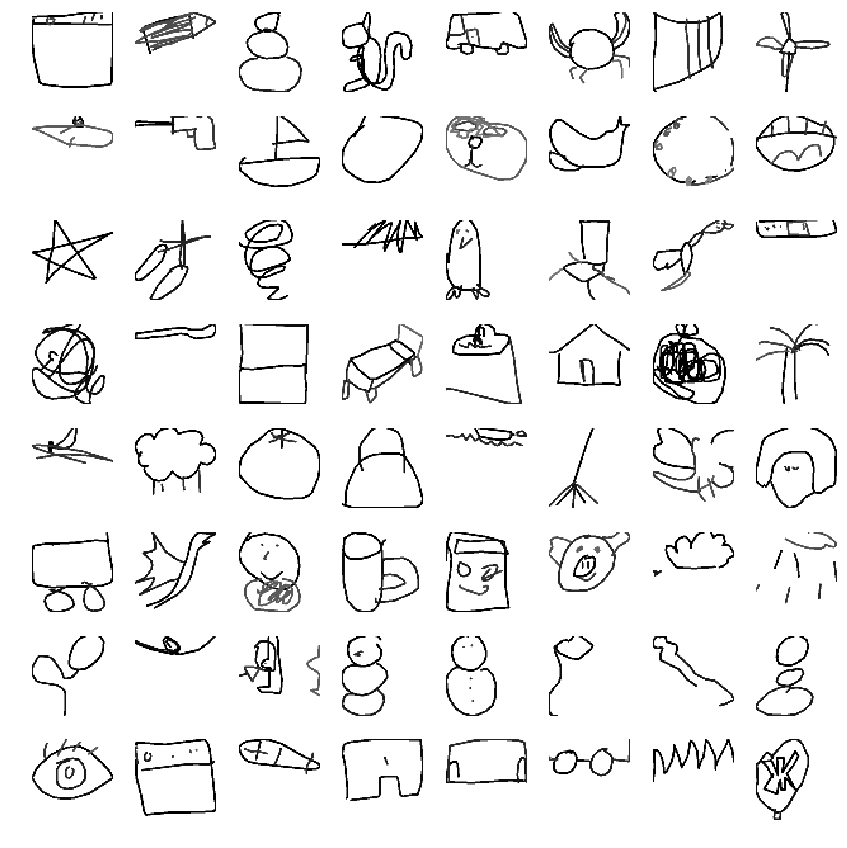

In [97]:
x, y = next(train_datagen)
print(x.shape)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show()

In [98]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]

In [99]:
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/70
800/800 [==============================] - 132s 165ms/step - loss: 2.9770 - categorical_crossentropy: 2.9770 - categorical_accuracy: 0.3348 - top_3_accuracy: 0.5278 - val_loss: 2.1654 - val_categorical_crossentropy: 2.1654 - val_categorical_accuracy: 0.4831 - val_top_3_accuracy: 0.6993
Epoch 2/70
800/800 [==============================] - 125s 156ms/step - loss: 2.0076 - categorical_crossentropy: 2.0076 - categorical_accuracy: 0.5114 - top_3_accuracy: 0.7241 - val_loss: 1.7715 - val_categorical_crossentropy: 1.7715 - val_categorical_accuracy: 0.5624 - val_top_3_accuracy: 0.7693
Epoch 3/70
800/800 [==============================] - 125s 156ms/step - loss: 1.7889 - categorical_crossentropy: 1.7889 - categorical_accuracy: 0.5608 - top_3_accuracy: 0.7648 - val_loss: 1.6311 - val_categorical_crossentropy: 1.6311 - val_categorical_accuracy: 0.5938 - val_top_3_accuracy: 0.7940
Epoch 4/70
800/800 [==============================] - 125s 156ms/step - loss: 1.6800 - categorical_crossen

Epoch 28/70
800/800 [==============================] - 125s 156ms/step - loss: 1.2442 - categorical_crossentropy: 1.2442 - categorical_accuracy: 0.6883 - top_3_accuracy: 0.8554 - val_loss: 1.1634 - val_categorical_crossentropy: 1.1634 - val_categorical_accuracy: 0.7037 - val_top_3_accuracy: 0.8666
Epoch 29/70
800/800 [==============================] - 125s 156ms/step - loss: 1.2416 - categorical_crossentropy: 1.2416 - categorical_accuracy: 0.6889 - top_3_accuracy: 0.8560 - val_loss: 1.1633 - val_categorical_crossentropy: 1.1633 - val_categorical_accuracy: 0.7074 - val_top_3_accuracy: 0.8664
Epoch 30/70
800/800 [==============================] - 125s 156ms/step - loss: 1.2369 - categorical_crossentropy: 1.2369 - categorical_accuracy: 0.6898 - top_3_accuracy: 0.8561 - val_loss: 1.1535 - val_categorical_crossentropy: 1.1535 - val_categorical_accuracy: 0.7061 - val_top_3_accuracy: 0.8673
Epoch 31/70
800/800 [==============================] - 128s 160ms/step - loss: 1.2292 - categorical_cro

800/800 [==============================] - 125s 156ms/step - loss: 1.1363 - categorical_crossentropy: 1.1363 - categorical_accuracy: 0.7141 - top_3_accuracy: 0.8714 - val_loss: 1.0659 - val_categorical_crossentropy: 1.0659 - val_categorical_accuracy: 0.7289 - val_top_3_accuracy: 0.8807
Epoch 54/70
800/800 [==============================] - 126s 157ms/step - loss: 1.1372 - categorical_crossentropy: 1.1372 - categorical_accuracy: 0.7139 - top_3_accuracy: 0.8716 - val_loss: 1.0668 - val_categorical_crossentropy: 1.0668 - val_categorical_accuracy: 0.7283 - val_top_3_accuracy: 0.8821
Epoch 55/70
800/800 [==============================] - 125s 156ms/step - loss: 1.1349 - categorical_crossentropy: 1.1349 - categorical_accuracy: 0.7142 - top_3_accuracy: 0.8720 - val_loss: 1.0630 - val_categorical_crossentropy: 1.0630 - val_categorical_accuracy: 0.7281 - val_top_3_accuracy: 0.8816
Epoch 56/70
800/800 [==============================] - 125s 156ms/step - loss: 1.1328 - categorical_crossentropy: 1

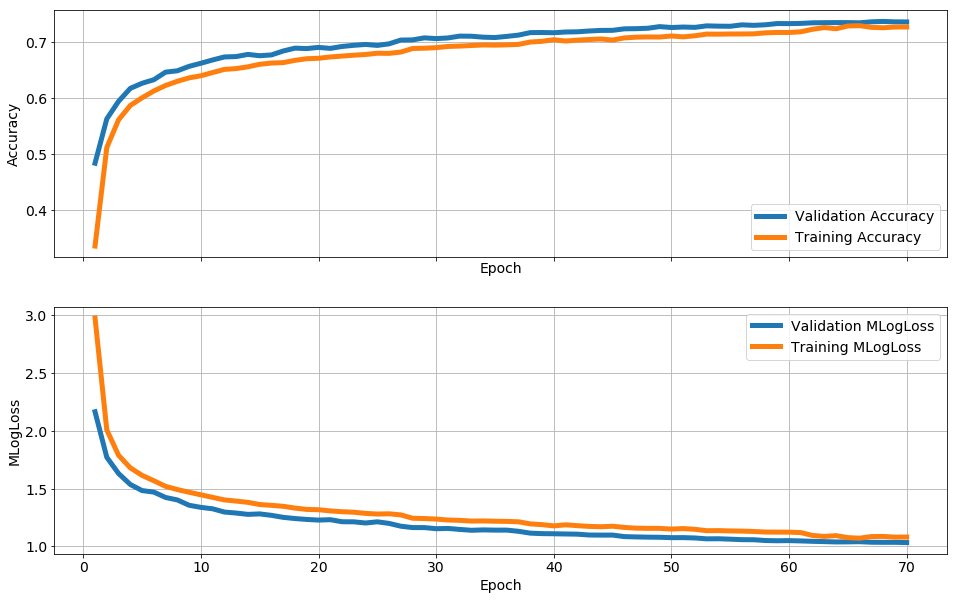

In [100]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show()
hist_df.to_csv("history_of_grayscale.csv")

In [101]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 3s 97us/step
Map3: 0.802


In [102]:
model.save_weights("Ladygaga.h5")

In [103]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [105]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 8s 73us/step


(112199, 3)

In [106]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_{}2thtestwithlargerdata.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

(112199, 2)